In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud    import WordCloud
%matplotlib inline
import matplotlib.cm as cm

from sklearn.metrics import silhouette_samples,silhouette_score
from sklearn.decomposition import LatentDirichletAllocation as LDA

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import Normalizer


In [2]:
#importamos spacy
import spacy


In [3]:
!python -m spacy download es_core_news_sm


     |████████████████████████████████| 16.2MB 3.7MB/s 
  Created wheel for es-core-news-sm: filename=es_core_news_sm-2.2.5-cp36-none-any.whl size=16172934 sha256=80de849897e833c3f76f84e5452c3d1fdd08308006e034a2a1abf530d7338fb5
  Stored in directory: /tmp/pip-ephem-wheel-cache-9jhpt0hn/wheels/05/4f/66/9d0c806f86de08e8645d67996798c49e1512f9c3a250d74242
Successfully built es-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [4]:
nlp= spacy.load('es_core_news_sm')


In [9]:
stop_ws= nlp.Defaults.stop_words
#stop_ws

In [10]:
df = pd.read_csv('/content/DatasetAsistocovid.csv')


In [11]:
#eliminamos las preguntas no respondidas por el bot durante la etapa de entrenamiento. descartamos los primeros 300 mensajes ('supermercado', 'sintomas', 'correo')
df = df.drop(df.index[0:400])
df

,ID_evento,ID_conversacion,evento,categoria,confidence,texto,fecha,hora
400,400,838c657c-8427-4978-a32e-9e095be3be5e,bot,NaN,NaN,"Mi nombre es Maria Luisa, algunos me apodan Ma...",26-3-2020,12:33:39
401,401,597b430d-75ac-4feb-a764-0beb9f406824,user,ask_weather,0.297241,"temperatura ambiente mayor a 26 grados, mata e...",26-3-2020,12:33:49
402,402,597b430d-75ac-4feb-a764-0beb9f406824,bot,NaN,NaN,Winter is coming ⚔️,26-3-2020,12:33:49
403,403,838c657c-8427-4978-a32e-9e095be3be5e,user,ask_joke_request,0.247156,Cómo me llamo,26-3-2020,12:33:53
404,404,838c657c-8427-4978-a32e-9e095be3be5e,bot,NaN,NaN,Ayer me caí y pensé que me había roto el peron...,26-3-2020,12:33:53
...,...,...,...,...,...,...,...,...
21490,21490,1af62362feee4639aec27febab6ea0ad,user,ask_datos,0.984202,cuantos casos hay,27-5-2020,9:30:16
21491,21491,1af62362feee4639aec27febab6ea0ad,bot,NaN,NaN,En la fecha 26/05/2020 en la provincia de Córd...,27-5-2020,9:30:18
21492,21492,1af62362feee4639aec27febab6ea0ad,user,ask_restaurantes,0.978884,puedo pedir delivery,27-5-2020,9:30:31
21493,21493,1af62362feee4639aec27febab6ea0ad,bot,NaN,NaN,Solo pueden trabajar restaurantes que hagan de...,27-5-2020,9:30:31


In [12]:
dfnr = df.loc[df[(df.texto.str.contains('^Disculpame', na=False))|(df.texto.str.contains('^Perdón', na=False)) ].index -1]

In [13]:
dfnr= dfnr[~dfnr.texto.str.contains('^/', na=False)]
dfnr = dfnr.texto
dfnr = dfnr.dropna()
dfnr 


407      se contagia teniendo relaciones sexuales?
409                                        Llueve?
417                                    Tomas mate?
424       Cuando se considera curado un infectado?
431                             Andate a la mierda
                           ...                    
21365              TESTING nuevos casos en Córdoba
21370              TESTING nuevos casos en Córdoba
21428                                         gfdg
21430                                           hi
21447                   is testing possible for it
Name: texto, Length: 2206, dtype: object

In [14]:
dfnr= pd.DataFrame(dfnr)
dfnr

,texto
407,se contagia teniendo relaciones sexuales?
409,Llueve?
417,Tomas mate?
424,Cuando se considera curado un infectado?
431,Andate a la mierda
...,...
21365,TESTING nuevos casos en Córdoba
21370,TESTING nuevos casos en Córdoba
21428,gfdg
21430,hi


## Preprocesamieto

In [15]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopws = set(stopwords.words('spanish'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
from nltk import SnowballStemmer
stemmer = SnowballStemmer ('spanish')

In [17]:
def clean(doc):

  doc = doc.lower().replace('á','a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u') # removemos minúsculas y tildes
  doc = re.sub('[^a-zA-Z]',' ', doc) #removemos caracteres especiales y numeros.
  doc = doc.replace('covid', 'virus').replace('coronavirus','virus').replace('corona','virus')#reemplazamos covid por virus
  doc = [word for word in doc.split(' ') if word not in stop_ws] #removemos stopwords
  doc = ' '.join(doc)
  #doc = [stemmer.stem(word) for word in doc.split(' ')]
  #doc = ' '.join(doc)
  return doc


In [18]:
dfnr['texto_limpio']= dfnr.texto.apply(clean)
dfnr.sample(10)

,texto,texto_limpio
10670,¿Puedo viajar a Buenos Aires desde Córdoba?,viajar a aires cordoba
2286,Que pasa si tengo hijos y estoy separado?,pasa hijos y separado
16688,En que fase de cuarentena estamos?,fase cuarentena
8534,puedo salir a cenar con mi familia,salir a cenar familia
21312,TESTING nuevos casos en Córdoba,testing casos cordoba
6002,Donde dirigirme si tengo sintomas,dirigirme sintomas
11316,grupos de riesgp,grupos riesgp
3644,Que feo,feo
9220,cuando empiezo a toser por el covid,empiezo a toser virus
10047,que es covid,virus


In [19]:

from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups
def lematize(tok):
  lookups = Lookups()
  lookups.add_table("lemma_rules", {"noun": [["s", ""]]})
  lemmatizer = Lemmatizer(lookups)

  if tok.pos_== 'VERB':
    tok= tok.lemma_
  elif tok.pos_=='NOUN':
    tok = lemmatizer(tok.text, tok.pos_)[0]
  else:
    tok
  return tok

In [20]:
lemm = []
for sent in dfnr.texto_limpio:
    tokens = nlp(sent)
    lem= [lematize(tok)for tok in tokens]
    lem = ' '.join(tok.text for tok in tokens)
    lemm.append(lem)



In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfvectorizer = TfidfVectorizer( stop_words=stop_ws ,max_df=0.90, min_df=3, ngram_range=(1,1))
Xtf = tfvectorizer.fit_transform(lemm)

In [22]:



Xtf.shape

(2206, 442)

In [23]:
## reduccion de dimensionalidad : quitamos outliers? 
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=30, algorithm='randomized', random_state=12)
normalizer = Normalizer(copy=False) # kmeans de sklearn no tiene dist coseno
lsa = make_pipeline(svd, normalizer)

X1 = lsa.fit_transform(Xtf)

## Análisis de clusters: KMeans

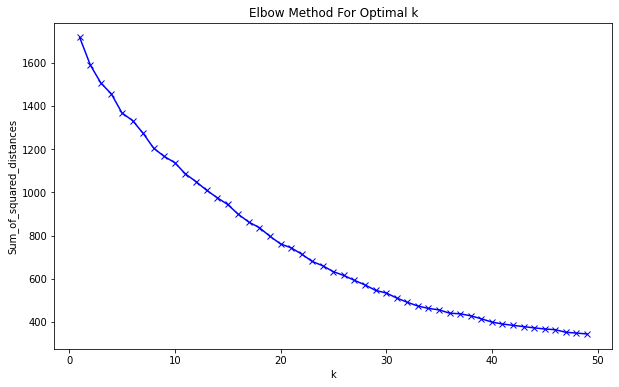

In [24]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, verbose=False, random_state=12, algorithm = 'full')
    km = km.fit(X1)
    Sum_of_squared_distances.append(km.inertia_)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.savefig('elbowmethod.jpg')
plt.show()


In [25]:
km_clust = KMeans(n_clusters=30, init='k-means++', n_init=10, verbose=False, random_state=12)
km_clust.fit(X1)
dfnr['label']= km_clust.labels_
dfnr

,texto,texto_limpio,label
407,se contagia teniendo relaciones sexuales?,contagia teniendo relaciones sexuales,19
409,Llueve?,llueve,1
417,Tomas mate?,tomas mate,25
424,Cuando se considera curado un infectado?,curado infectado,27
431,Andate a la mierda,andate a mierda,1
...,...,...,...
21365,TESTING nuevos casos en Córdoba,testing casos cordoba,26
21370,TESTING nuevos casos en Córdoba,testing casos cordoba,26
21428,gfdg,gfdg,1
21430,hi,hi,14


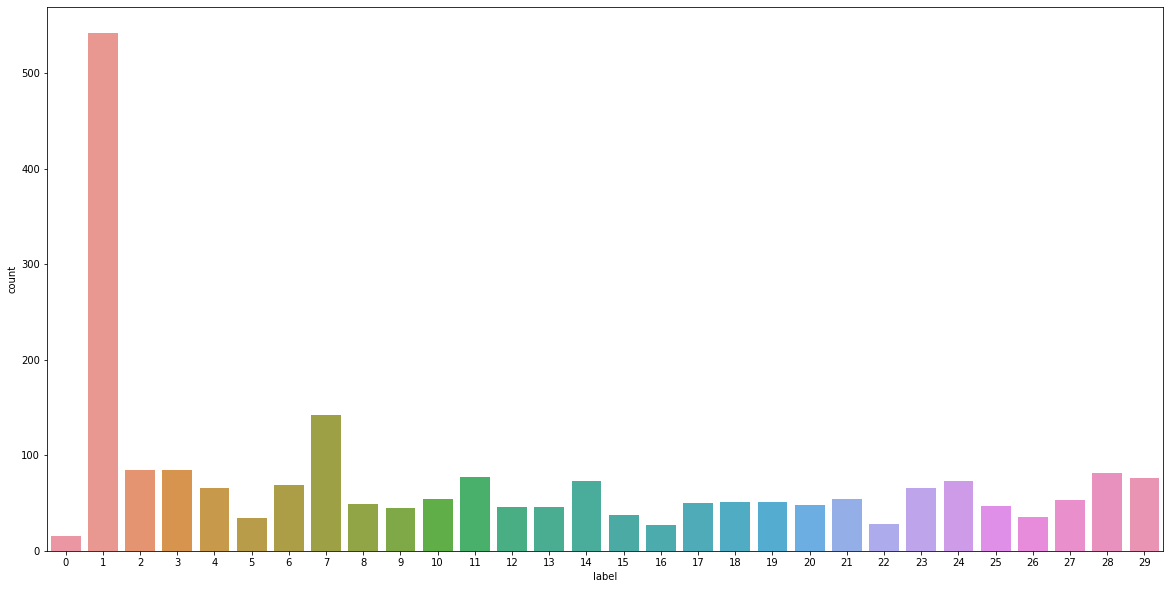

In [26]:
plt.figure(figsize=(20,10))
sns.countplot(x= 'label', data=dfnr)
plt.savefig('cluster_frec_kmeans.jpg')

In [27]:
k=km_clust.n_clusters
BOLD = '\033[1m'
END = '\033[0m'
for i in range(k):

  print (BOLD+'\n Frases del Cluster {}\n'.format(i)+END,end='\n')
  print (dfnr[dfnr.label==i].texto[0:10])


 Frases del Cluster 0

468     quiero saber a que se dedica kunan
1507                          que es kunan
1512                        que hace kunan
1517                       que hace kunan?
1860                         Qué es Kunan?
4767                Como trabajar en kunan
6799        EL pelado de kunan se la come?
7380                         Que es kunan?
8291                          que es kunan
9274                          que es kunan
Name: texto, dtype: object

 Frases del Cluster 1

409                                              Llueve?
431                                   Andate a la mierda
433                                           Me querés?
706                       ¿Quiénes pueden ir a trabajar?
741    ¿Qué caducidad tiene la preparación de alcohol...
749                Estoy aburrida y bsjoneada, qué hago?
785                                PUEDO HACER UN CUMPLE
797                          Puedo contratar una niñera?
894                           Puedo usa

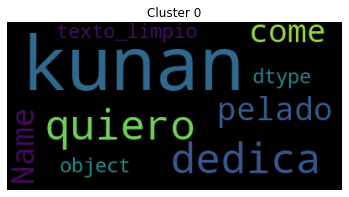

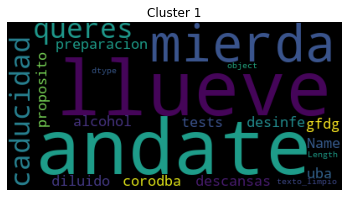

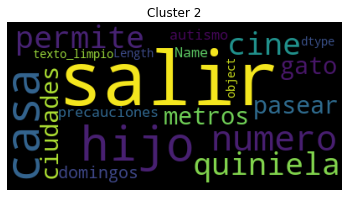

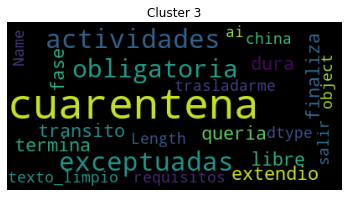

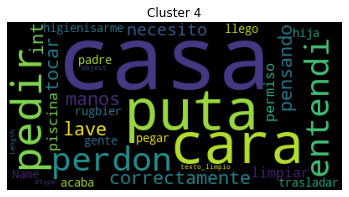

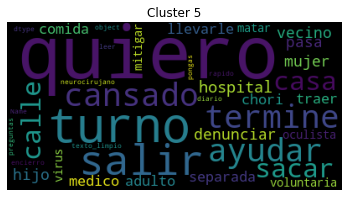

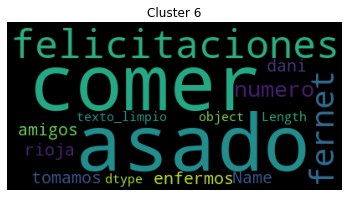

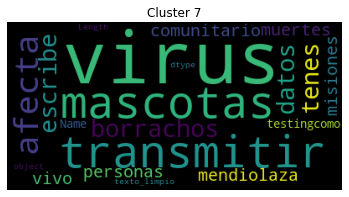

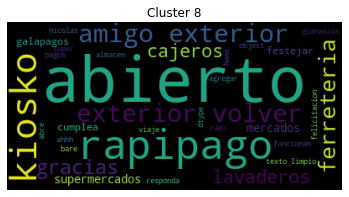

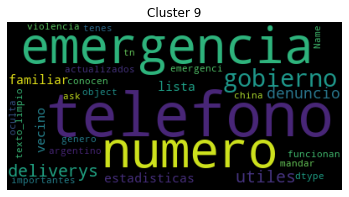

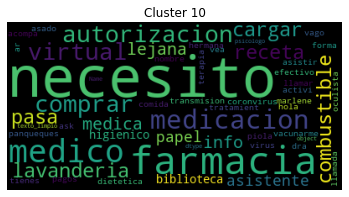

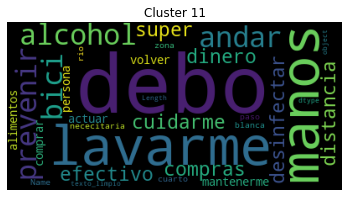

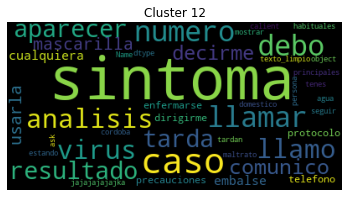

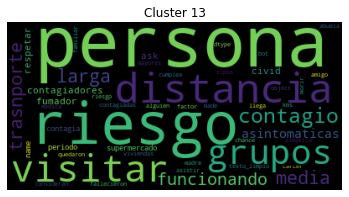

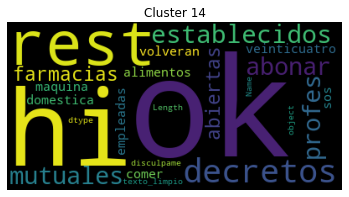

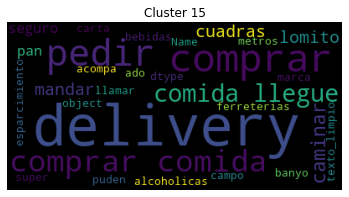

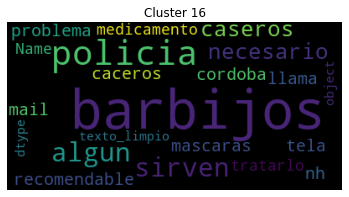

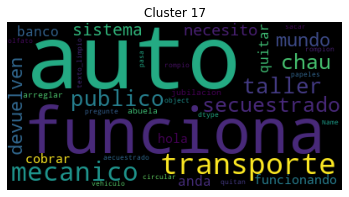

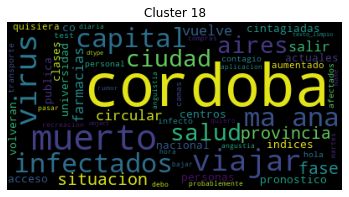

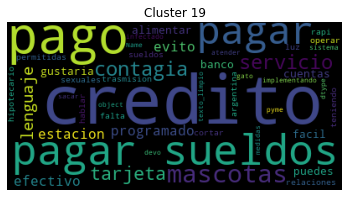

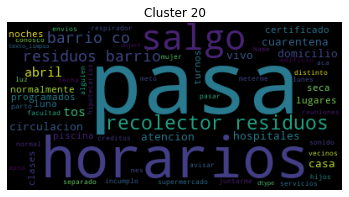

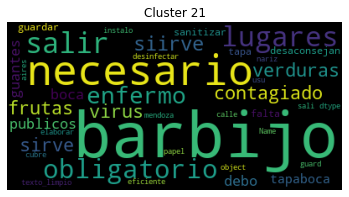

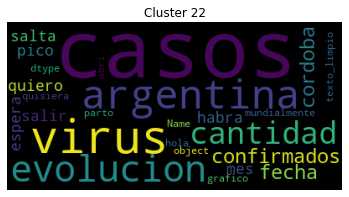

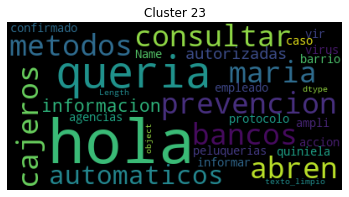

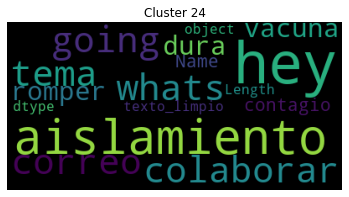

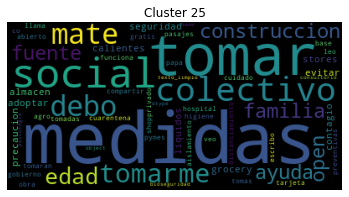

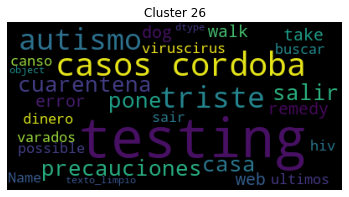

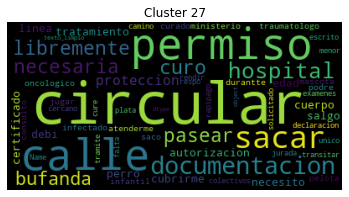

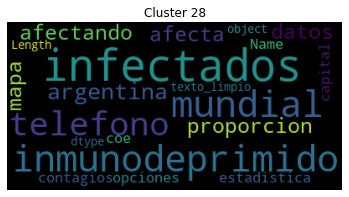

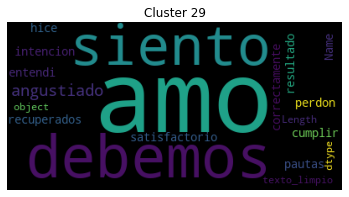

In [30]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud().generate(str(data))
    fig = plt.figure(1, figsize=(6, 6))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

#show_wordcloud(dfnr[dfnr.label==5].clean)

for i in range(km_clust.n_clusters):
  

  plt.title('Cluster {}'.format(i))

  show_wordcloud(dfnr[dfnr.label==i].texto_limpio)

## Latent Dirichlet Allocation

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer(max_df=0.95, stop_words=stop_ws, ngram_range=(1,2), min_df=3)
tf = tf_vectorizer.fit_transform(lemm)
tf_feature_names = tf_vectorizer.get_feature_names()
tf.shape

(2206, 639)

In [32]:
lda = LDA(n_components=30, max_iter=15, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda.components_.shape

(30, 639)

In [33]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [37]:

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, 5)


Topics in LDA model:
Topic #0: cordoba contagio medidas cuido tomar
Topic #1: hola alcohol sirve dinero actividades
Topic #2: cobrar ok banco empresa algun
Topic #3: salir casa salir casa precauciones precauciones salir
Topic #4: colectivo mortalidad llamas tomarme tomarme colectivo
Topic #5: testing hey incubacion sair servicios
Topic #6: autismo autorizacion for chau are
Topic #7: vacuna personas distancia asistir funcionando
Topic #8: riesgo infectados persona salir papel
Topic #9: tenes aplicacion prevenir desarrollo aplicacion desarrollo
Topic #10: fase ana ma ma ana sos
Topic #11: desinfectar mascotas contagia verduras hospital
Topic #12: numeros emergencia test exceptuados ask
Topic #13: pasa comprar necesito pagar farmacia
Topic #14: muertos span lavandina violencia genero genero
Topic #15: aislamiento deliverys fuente excepciones romper aislamiento
Topic #16: casos casos cordoba testing casos abiertos contagiar
Topic #17: virus sintomas triste cura caso
Topic #18: auto cajero

In [38]:
doc_topic = lda.transform(tf)
lda_labels = [doc_topic[i].argmax() for i in range(doc_topic.shape[0])]
dfnr['lda'] = lda_labels
doc_topic.shape

(2206, 30)

In [39]:
BOLD = '\033[1m'
END = '\033[0m'
for i in range(doc_topic.shape[1]):

  print (BOLD+'\n Frases del Cluster {}\n'.format(i)+END,end='\n')
  print (dfnr[dfnr.lda==i].texto[0:10])


 Frases del Cluster 0

409                                     Llueve?
424    Cuando se considera curado un infectado?
431                          Andate a la mierda
433                                  Me querés?
498                             Whats going on?
505                                Have a rest!
511                                  Piola vago
550                                 Soy nicolas
555                Farmacias en Córdoba capital
706              ¿Quiénes pueden ir a trabajar?
Name: texto, dtype: object

 Frases del Cluster 1

559                                            Hola María
670     ¿Qué actividades están exceptuadas de la cuare...
704     ¿Qué actividades están exceptuadas para libre ...
741     ¿Qué caducidad tiene la preparación de alcohol...
898              Hola! Se puede ir a cajeros automáticos?
1110                       Puedo sacar a pasear al perro?
1216                           se permite pasear al gato?
1424                   puedo sacar a pa

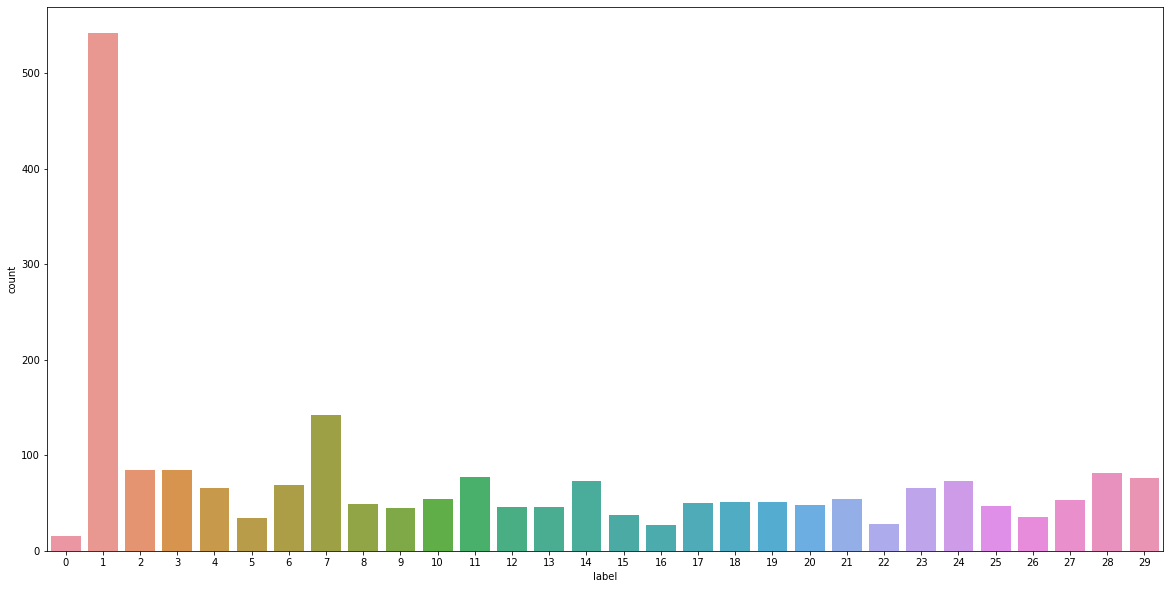

In [40]:
plt.figure(figsize=(20,10))
sns.countplot(x= 'label', data=dfnr)
plt.savefig('frecs_kmeans.jpg')

##Reduccion de dimensionalidad: tSNE

In [41]:
lda.components_.shape

(30, 639)

In [42]:
from sklearn.manifold import TSNE
def plot_tsne(model, label):
  X_tsne = TSNE(n_components=2).fit_transform(model)
  tsne_df = pd.DataFrame({'X':X_tsne[:,0],
                          'Y':X_tsne[:,1],
                          'Z':label})
  plt.figure(figsize=(20,10))
  sns.scatterplot(x="X", y="Y",
                hue='Z',
                palette= 'bright',
                legend='full',
                data=tsne_df);


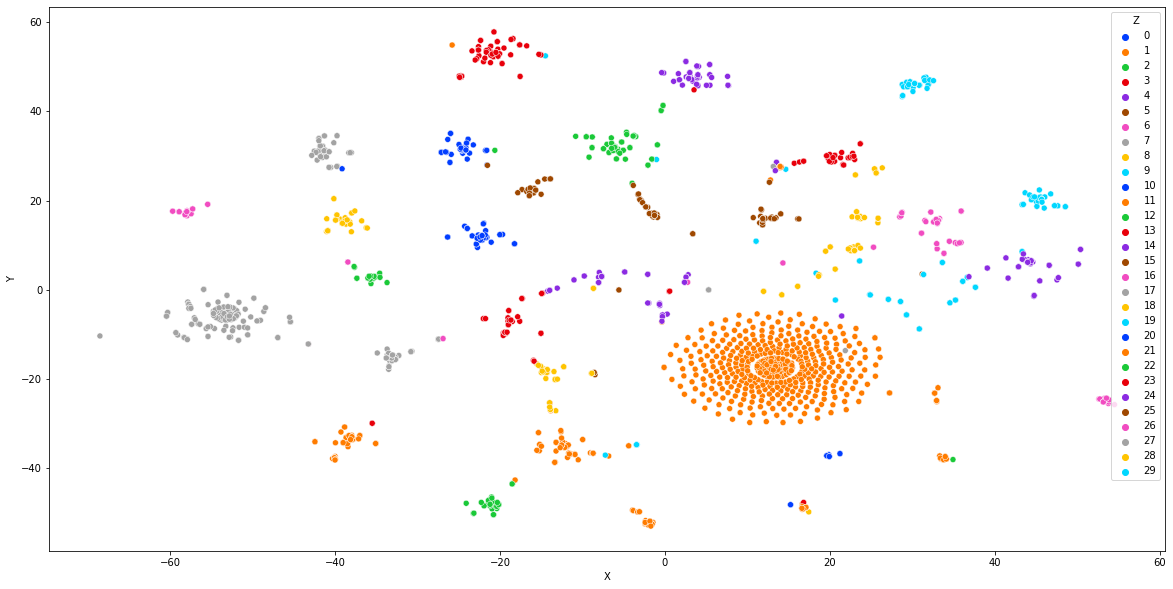

In [43]:
plot_tsne(X1, dfnr.label)# hacemos reduccion de dimensionalidad del modelo de k-means

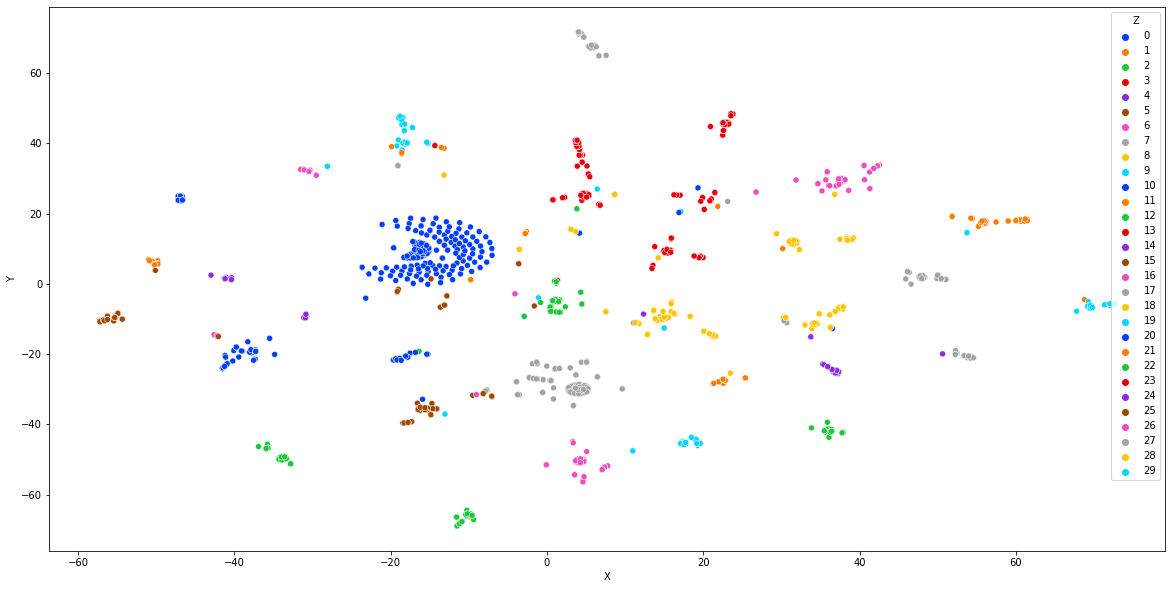

In [44]:
plot_tsne(doc_topic, dfnr.lda)# hacemos reduccion de dimensionalidad de LDA



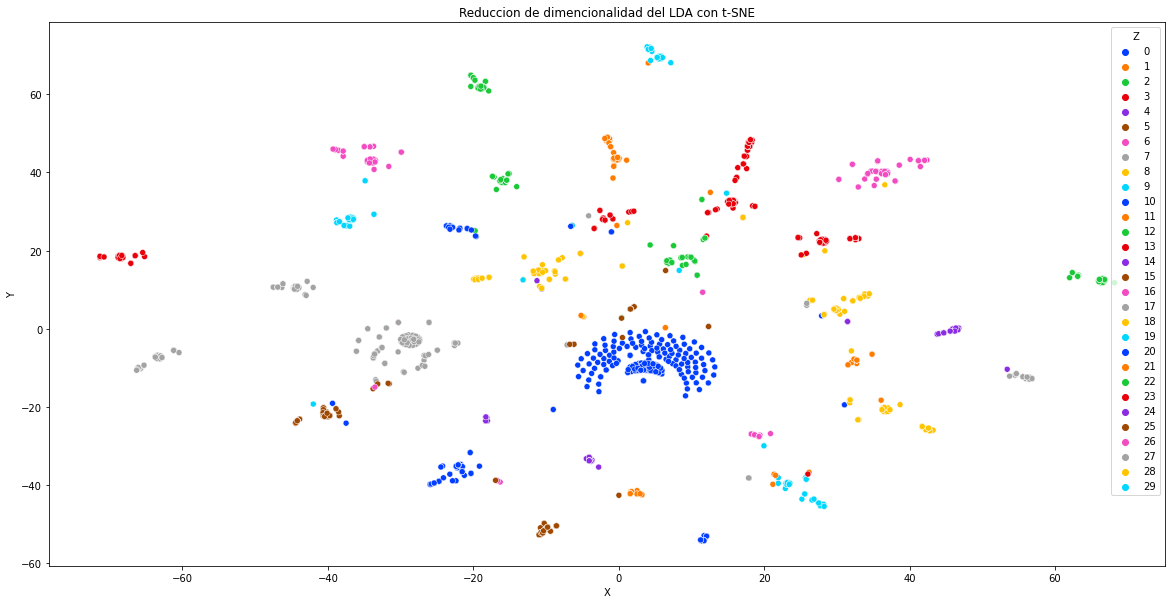

In [45]:
X_tsne = TSNE(n_components=2, perplexity=30).fit_transform(doc_topic)
tsne_df = pd.DataFrame({'X':X_tsne[:,0],
                          'Y':X_tsne[:,1],
                          'Z':dfnr.lda})
plt.figure(figsize=(20,10))
sns.scatterplot(x="X", y="Y",
              hue='Z',
              palette= 'bright',
              legend='full',
              data=tsne_df);
plt.title('Reduccion de dimencionalidad del LDA con t-SNE')
plt.savefig('lda_tsne.jpg')

## Embeddings pre-entrenados: Word2Vec

In [48]:
import gensim
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Doc2Vec

In [49]:
########################
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content_train = []
j=0
for em in lemm:
    all_content_train.append(LabeledSentence1(em,[j]))
    j+=1
print("Number of texts processed: ", j)


Number of texts processed:  2206


In [50]:
d2v_model = Doc2Vec(all_content_train, vector_size = 100, window = 10, min_count = 5, workers=7, dm = 1,alpha=0.025, min_alpha=0.001)
d2v_model.train(all_content_train, total_examples=d2v_model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

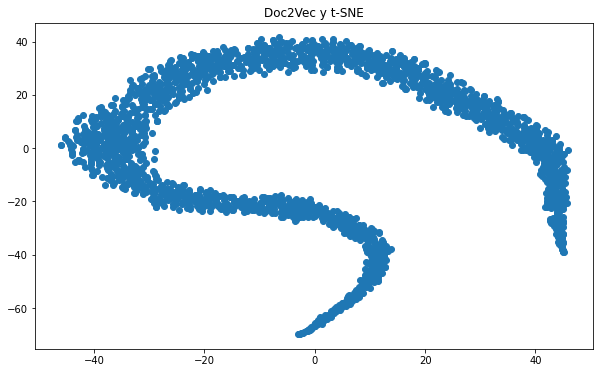

In [51]:
kmeans_model = KMeans(n_clusters=4, init="k-means++", max_iter=100) 
Xsvd = TruncatedSVD(n_components=30).fit(d2v_model.docvecs.vectors_docs)
Xsvd = Xsvd.transform(d2v_model.docvecs.vectors_docs)
X = kmeans_model.fit(Xsvd)
labels=kmeans_model.labels_.tolist()
l = kmeans_model.fit_predict(Xsvd)
pca = TSNE(n_components=2).fit(Xsvd)
datapoint = pca.fit_transform(Xsvd)
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,6))
plt.figure
#label1 = ["#FFFF00", "#008000", "#0000FF", "#800080"]
#color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1])
#centroids = kmeans_model.cluster_centers_
#centroidpoint = pca.transform(centroids)
#plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker="^", s=150, c="#000000")

plt.title('Doc2Vec y t-SNE')
plt.savefig('d2v_tsne.jpg')
plt.show()